# DS405 Machine Learning Applications in Business and Economics Mini-Project
---

<font color="red">TBD: 
- What features to use? 
    - Construct new ones? 
    - Simply leave out all non-numeric features? 
    - Delivery-Delay might be interesting
    

</font>


## Introduction

In the realm of e-commerce, a common observation is that a significant proportion of customers engage in a single transaction and then cease further purchases. This phenomenon can be attributed to a multitude of factors. To mitigate this, e-commerce platforms employ a variety of strategies aimed at fostering customer loyalty. One such strategy involves the distribution of discount vouchers subsequent to the initial purchase, with the goal of incentivizing repeat transactions. However, indiscriminate distribution of these vouchers may not be an optimal strategy. This is because a segment of customers might have engaged in repeat purchases even in the absence of such incentives. Consequently, the redemption of these vouchers by such customers translates into a reduction in the retailer’s profit. Empirical analyses conducted by the media retailer have demonstrated that for 10% of non-buyers, the voucher instigates a purchase with an average order value of €20. Thus, if a voucher is dispatched to a customer who would not have actually made another purchase, the revenue increases by an average of €1.5. On the other hand, sending a voucher to a customer who would have made a purchase anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues. Therefore, it is crucial to devise a more targeted approach for the distribution of these vouchers.

## Task 

The task at hand involves constructing a predictive model that leverages various features associated with a customer’s initial order. The objective is to determine whether a €5.00 voucher should be issued to a specific customer. Detailed descriptions of these features can be found in the data dictionary.pdf file.
The model should be designed to predict if a customer will place a subsequent order within a 90-day period following their initial purchase. This information is represented by the target90 variable in the dataset. The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.


---

In [44]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Binary dependent variable
from sklearn.model_selection import RandomizedSearchCV

### Step 1: Reading in and getting an overview of the data

In [45]:
# Separator is ;
train = pd.read_csv("train.csv", sep = ";")
# Get number of rows and columns
print(train.shape)

# Get overview via .describe()
# Dataset is wide, print all rows and only first 15 columns
train.describe().iloc[:,0:15]

(32428, 38)


C:\Users\benny\AppData\Local\Temp\ipykernel_29680\3868431855.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", sep = ";")


,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.0
mean,33389.298569,0.541569,0.006969,7.517115,0.169483,1.646910,1.000987,0.201955,48.752282,0.162020,2.934378,2.019551,0.004564,0.414642,0.0
std,19148.090449,0.657044,0.083192,3.683945,0.375184,0.825981,1.092677,0.401465,24.361425,0.368475,1.319270,1.726046,0.067404,0.492668,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,16802.750000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0
50%,33552.500000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000,0.000000,47.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0
75%,50034.250000,1.000000,0.000000,11.000000,0.000000,2.000000,2.000000,0.000000,66.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0
max,66251.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,50.000000,1.000000,1.000000,0.0


In [46]:
# Second half of the columns
# Dataset is wide, print all rows and only remaining columns
train.describe().iloc[:,15:]

,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000
mean,0.150611,637.920809,0.059979,0.061613,0.068860,0.902122,0.404342,0.276644,0.018903,0.047027,0.180986,0.027908,0.023128,0.000185,0.164981,0.092883,0.186598
std,0.357674,724.358131,0.388740,0.306833,0.474444,1.654767,1.410395,1.353981,0.253596,0.434265,0.561751,0.299862,0.401782,0.013601,0.836705,0.610509,0.389594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,494.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,920.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,20076.000000,19.000000,17.000000,19.000000,99.000000,84.000000,90.000000,15.000000,36.000000,14.000000,27.000000,55.000000,1.000000,48.000000,50.000000,1.000000


Every column has a count of 32428 -> No missing values seem to be present. In the case of binary encoded variables, the mean directly reflects a percentage (if multiplied by 100).
However, due to their datatype, some columns are not present in the .describe()-dataframe. Therefore, to fully detect all missing values, we loop over all columns in the as follows:

In [47]:
# Function to check for NAs in every column
def count_na(df):
    for col in df.columns:          # Loop over all columns
        n_na = df[col].isna().sum() # Count occurrences of missing values
        if n_na > 0:                # Only give column and count if there actually are NAs
            print(col, n_na)        # Print column name and number of NAs

# Apply function
count_na(train)

delivpostcode 31036
advertisingdatacode 25905


We only seem to have missing values in the *delivpostcode* and the *advertisingdatacode* column. \
One possible approach of fixing the issue in the *delivpostcode* column would be to simply impute the values of the *invoicepostcode* column. However, these values do not necessarily have to match. \
For the *advertisingdatacode* column, we do not have a logical approach of dealing with these rather unique data type and its missing values. We therefore work with the column as it is. 

---

### First try of estimation with RandomForestClassifier

In [48]:
# Only includes training data for now 
def evaluate_model(Y_train, Y_train_pred):
    # Calculate accuracy
    accuracy = sum(Y_train == Y_train_pred) / len(Y_train)
    # Calculate true positive rate
    tpr = sum((Y_train == 1) & (Y_train_pred == 1)) / sum(Y_train == 1)
    # Calculate false positive rate
    fpr = sum((Y_train == 0) & (Y_train_pred == 1)) / sum(Y_train == 0)
    # Calculate true negative rate
    tnr = sum((Y_train == 0) & (Y_train_pred == 0)) / sum(Y_train == 0)
    # Calculate false negative rate
    fnr = sum((Y_train == 1) & (Y_train_pred == 0)) / sum(Y_train == 1)
    # Print results
    print("Accuracy:", accuracy)
    print("True positive rate:", tpr)
    print("False positive rate:", fpr)
    print("True negative rate:", tnr)
    print("False negative rate:", fnr)

In [49]:
# Construct training data set to contain only numeric variables (as listed in .describe())
X_train = train[train.describe().columns].drop(columns = ["target90"])
# Construct dependent variable
Y_train = train["target90"]

In [50]:
# Simple classifier setting some intuitive parameters
forest = RandomForestClassifier(n_estimators = 10, max_depth = 5, min_samples_split = 10, min_samples_leaf = 10, criterion = "entropy")
forest.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=10)

In [51]:
# Get Model predictions
Y_train_pred = forest.predict(X_train)

In [52]:
# Evaluate accuracy of cross-validated model 
evaluate_model(Y_train, Y_train_pred)

Accuracy: 0.8134019982730973
True positive rate: 0.0
False positive rate: 0.0
True negative rate: 1.0
False negative rate: 1.0


In [53]:
# Conduct RandomizedSearchCV over input parameters

max_depth = range(5,15) 
min_samples_split = range(5,20)
min_samples_leaf = range(5,20)
n_estimators = range(10,100)
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

forest = RandomForestClassifier()
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs=-1, cv=10,verbose=1, n_iter=100, scoring='accuracy')
forest_cv.fit(X_train,Y_train) # does it automatically use best parameters? 

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 15),
                                        'min_samples_leaf': range(5, 20),
                                        'min_samples_split': range(5, 20),
                                        'n_estimators': range(10, 100)},
                   scoring='accuracy', verbose=1)

In [54]:
# Feature importance
print(forest_cv.best_estimator_.feature_importances_)

[0.11836955 0.03427703 0.00113877 0.05845633 0.05950419 0.0232945
 0.02347875 0.04028751 0.11198951 0.01487385 0.04886021 0.05221467
 0.00035233 0.02304161 0.         0.02712315 0.11927898 0.08705147
 0.0063451  0.01292979 0.03851325 0.02765601 0.01452479 0.00771839
 0.0032339  0.01209482 0.00289059 0.00116062 0.         0.01868053
 0.01065982]


In [55]:
# Optimal parameters
forest_cv.best_params_

{'n_estimators': 10,
 'min_samples_split': 12,
 'min_samples_leaf': 10,
 'max_depth': 12}

In [56]:
Y_train_pred_cv = forest_cv.predict(X_train)

In [57]:
evaluate_model(Y_train, Y_train_pred_cv) # most likely overfitting 

Accuracy: 0.8150055507586037
True positive rate: 0.009585192530160304
False positive rate: 0.00022747090268036548
True negative rate: 0.9997725290973196
False negative rate: 0.9904148074698397


In [58]:
evaluate_model(Y_train, Y_train_pred)

Accuracy: 0.8134019982730973
True positive rate: 0.0
False positive rate: 0.0
True negative rate: 1.0
False negative rate: 1.0


Not really sure what to make of these results yet 

Text(0.5, 1.0, 'Random Forest Regression Feature Importances')

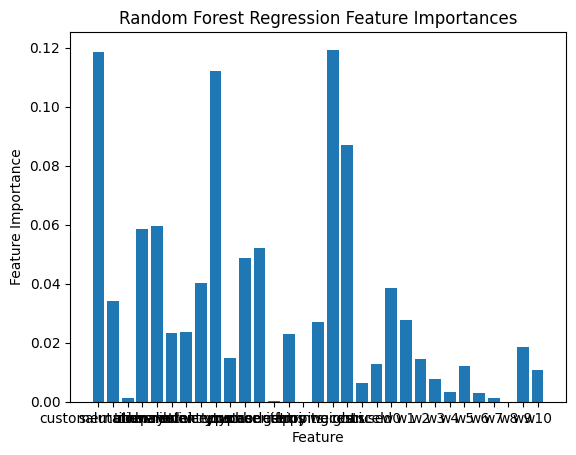

In [59]:
# Plot feature importance
fig = plt.figure()
ax = fig.gca() #get current axis
ax.bar(range(X_train.shape[1]), forest_cv.best_estimator_.feature_importances_)
ax.set_xticks(np.arange(X_train.shape[1]))
ax.set_xticklabels([f'{col}' for col in X_train.columns])
ax.set_xlabel('Feature')
ax.set_ylabel('Feature Importance')
ax.set_title('Random Forest Regression Feature Importances')

# Ugly ass graph but its working 